## Binary Addition using LSTM

In this notebook, we have trained a LSTM model to add two binary strings of `n` length and output the result as n-length binary string. The main purpose of this implementation is 

a) To observe the LSTM hidden state activations for a simple problem and understand its working. <br>
b) Understand the data feeding format into LSTMs <br>
c) Understand difference between stateless and stateful mode and its application during prediction task. <br>

Initially, for the binary addition task using LSTM, We started with model having 2 LSTM layers and 8 nodes each. However, we observed that a single layered LSTM with 3 nodes also suffices to give accurate addition of two bits. 

![LSTM%20binary%20addition](https://raw.githubusercontent.com/InFoCusp/ui_resources/master/lstm_deepdive_images/lstm_binary_addition.png)

Another finding was that a model trained for binary strings of length 3, since it has seen all possible cases of inputs bits, sum and carry - the model is generalized and robust enough and can be used for summation of n-length binary strings. For visualisation purpose, we have predicted the results for lengths upto 16. However, input strings of length > 16 can also be used.

In [1]:
%matplotlib inline

# import stuff
import numpy as np
from keras import Sequential
from keras.layers import Dense
import keras.backend as K
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns
import pprint
import random as rn

Using TensorFlow backend.


In [2]:
# Gotta print pretty!
pp = pprint.PrettyPrinter(indent=4, depth=4)

### Generating Training Dataset 

In [3]:
binary_dim = 8 # n-length binary string (We only require 3 bits but unpackbits works only for 8!)
largest_number = pow(2,binary_dim) # Setting highest no. to 256 so that we add atmost 8 digits(2^8)

print("Largest number of {} bit binary dimension : {}" .format(binary_dim, largest_number))

Largest number of 8 bit binary dimension : 256


Note that the (seemingly) last bit would need to go in first as that is the point where addition starts and the carry is to be moved forward. 

In [4]:
# Dictionary to store numbers converted into binary form
int2binary = {}
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)

for i in range(largest_number):
    int2binary[i] = np.flip(np.array(binary[i]), axis=0) 
    # Imp Note:
    # Storing in flipped format as the last bit has to go in first

##### For generating training samples:

A `training_generator` function generates the set of all training samples (all possible combinations for adding two binary strings for a fixed input length) which are used for training. We will only go from 0 to half of the largest number to avoid carry overflow cases.

`x_train` has two input binary strings to be added. It's dimensions are: <br>
     - 'num_samples x binary_length x number_of_inputs'. 
     - We may generate any number of possible samples. Say we are adding binary strings of 8-bit length each. In this case, binary_length= 8 and number_of_inputs= 2. It would be best practice to cover all possible combinations in the number of samples and not repeat in the manner explained above.

`y_train` has the binary representation of the output for each case. Thus, it has dimension: <br>
    -  'no_of_possible_samples x binary_length'

We are flipping the inputs and the outputs, as the RNN/LSTM model will read the input/output from left-to-right whereas binary addition is done from right-to-left.

![Untitled%20Diagram.png](https://raw.githubusercontent.com/InFoCusp/ui_resources/master/lstm_deepdive_images/rladd.png)

An explanation of how the data should be arranged to be fed into the LSTM in order is here. 
LSTM preserves state across inputs occuring in a sequence or at different times (sequence/ time being the 2nd dimension here). The features for a single time are fed into the LSTM all at once. Features for a single sample at a single time appear in dimension 3. 
We have multiple such samples of sequence_length x num_features dimension which is why num_samples makes up dimension 1. 

Thus, for our example, since we want to add 2 bits at a time, we have just 2 features. When training, we provide a bit stream or sequence of 3 pairs of 2 bits to be added in a sequence thus making sequence length 3.

We have multiple samples - where we have bitstreams added together to produce output as shown above. These samples make up our first dimension.

In [5]:
def training_generator(binary_dim, largest_number):
    x_train = np.expand_dims(np.array([np.zeros(binary_dim),np.zeros(binary_dim)]).T, axis=0)
    y_train = np.array([np.zeros(binary_dim)])
    
    for i in range(int(largest_number)):
        a_array = int2binary[i]
        
        for j in range(int(largest_number)):
            b_array = int2binary[j]
    
            x = np.expand_dims(np.array([a_array,b_array]).T, axis=0)
            y = [int2binary[i+j]]
        
            x_train = np.concatenate((x_train, x), axis=0)
            y_train = np.concatenate((y_train, y))
    
    y_train = np.expand_dims(y_train, axis=2)
    
    return x_train,y_train

Experimenting different aspects of this LSTM models, one finding was that we do not require 8-bit binary strings to train the model. Simply taking 3-bit binary strings also covers all the cases of binary addition of two bit (with and without previous carry). 

Thus, we have only used 3-bit strings to train the model. This parameter is defined below as the `sequence_length`. Different bit lengths may be used, but 3-bit length suffices to train the model and to generate accurate results.

##### Parameters to be set:

In [6]:
sequence_length = 3    # Length 3 suffices to train all the cases of binary addition

In [7]:
# Generating training data with bit length 8 and largest number 256 divided by 2 to prevent overflow
X_train, Y_train = training_generator(binary_dim, largest_number/2.0)

#Limiting input bit lengths to 3
X_train = X_train[:,:sequence_length] 
Y_train = Y_train[:,:sequence_length]

In [8]:
print('Shape of generated training data: \n')
print('Features shape: {}, \n Targets shape: {}'.format(X_train.shape, Y_train.shape))

Shape of generated training data: 

Features shape: (16385, 3, 2), 
 Targets shape: (16385, 3, 1)


### LSTM model:

In [9]:
nodes = 3   # Number of embedding cells in LSTM 
batch_size = 128
num_epochs = 12

In [10]:
# we have introduced a zero loss function since we're extracting LSTM state values and we 
# do not want any portion of it in total loss
def zero_loss(y_true, y_pred):
    return K.zeros_like(y_pred)

Image of model

In [11]:
def lstm_model(seq_len=binary_dim, EMBEDDING_DIM=nodes, batch_size=None, stateful=True):
    # Input
    source = tf.keras.Input(shape=(seq_len,2), batch_size=batch_size)
    print('Input shape: {}'.format(source.shape))

    # Layer 1: LSTM - return_sequences true since we want output at each time step
    lstm_1 = tf.keras.layers.LSTM(EMBEDDING_DIM, stateful=stateful, return_sequences=True)(source)
    print('LSTM output shape: {}'.format(lstm_1.shape))
    
    # Layer 2: Dense (If there was a single output at the end of all timesteps, this would be replaced by
    # Time distributed Dense)
    predicted_digit = tf.keras.layers.Dense(1, activation='sigmoid')(lstm_1)
    print('Dense layer output shape: {}'.format(predicted_digit.shape))
    
    # we want to store LSTM hidden state values for visualization at each step
    model = tf.keras.Model(inputs=[source], outputs=[predicted_digit,lstm_1])
    
    model.compile(
      optimizer=tf.train.RMSPropOptimizer(learning_rate=0.01),
      loss=['binary_crossentropy', zero_loss], # we have introduced a zero loss function for LSTM state values 
      metrics=['accuracy'])
    return model

In [12]:
# Create and fit the model
digit_model = lstm_model(seq_len=sequence_length, EMBEDDING_DIM=nodes, stateful=False)

digit_model.fit(X_train,
                [Y_train, np.zeros(Y_train.shape)], 
                epochs=num_epochs, 
                batch_size=batch_size, 
                validation_split=0.1)

Input shape: (?, 3, 2)
LSTM output shape: (?, 3, 3)
Dense layer output shape: (?, 3, 1)
Train on 14746 samples, validate on 1639 samples
Epoch 1/12
14746/14746 [==============================] - 1s 71us/step - loss: 0.6936 - dense_loss: 0.6936 - lstm_loss: 0.0000e+00 - dense_acc: 0.5083 - lstm_acc: 0.7219 - val_loss: 0.6907 - val_dense_loss: 0.6907 - val_lstm_loss: 0.0000e+00 - val_dense_acc: 0.4688 - val_lstm_acc: 0.6439
Epoch 2/12
14746/14746 [==============================] - 0s 30us/step - loss: 0.6053 - dense_loss: 0.6053 - lstm_loss: 0.0000e+00 - dense_acc: 0.7393 - lstm_acc: 0.6544 - val_loss: 0.4323 - val_dense_loss: 0.4323 - val_lstm_loss: 0.0000e+00 - val_dense_acc: 0.8892 - val_lstm_acc: 0.5646
Epoch 3/12
14746/14746 [==============================] - 0s 31us/step - loss: 0.2553 - dense_loss: 0.2553 - lstm_loss: 0.0000e+00 - dense_acc: 0.9405 - lstm_acc: 0.5128 - val_loss: 0.1359 - val_dense_loss: 0.1359 - val_lstm_loss: 0.0000e+00 - val_dense_acc: 0.9908 - val_lstm_acc: 0.5

In [13]:
# Save out weights
model_name = 'binary_addition_' + str(nodes) + '_nodes_1_layer_seqlen_3.h5'
digit_model.save_weights(model_name, overwrite=True)

### Make predictions with the model

Use the trained model to make predictions. Here, we take two binary input strings and feed the model bit by bit to predict the next bit in the output. The predicted output and the lstm states at each timestep is stored.


<b> Need for stateful model during prediction </b>
This is required so as to maintain the state till the binary addition is complete for the full bit stream. Say, we want to add 2 binary strings each of length 14 - then the state would need to be preserved from input to input of 2 bits each till the full 14 bits are done, as the state would be carrying useful information of carry over, etc. 
These can be reset once the binary addition for the full bit string is completed.

In [14]:
def predict(x, binary_dim, prediction_model):
    
    predicted_digit_o = []
    lstm_1_o = []
   
    prediction_model.reset_states() # Reset states at start of any new bit stream
    
    for i in range(binary_dim):
        [predicted_digit_temp,lstm_1_temp] = prediction_model.predict(x[:, i:i+1 ,:])
        predicted_digit_o.append(predicted_digit_temp[0,0,:])
        lstm_1_o.append(lstm_1_temp[0,0,:])
        
    return predicted_digit_o,lstm_1_o

In [15]:
prediction_model = lstm_model(seq_len=1,EMBEDDING_DIM=nodes, batch_size=1, stateful=True)
prediction_model.load_weights('/home/prakruti/Downloads/binary_addition_3_nodes_1_layer_seqlen_3_good_weights.h5')

Input shape: (1, 1, 2)
LSTM output shape: (1, 1, 3)
Dense layer output shape: (1, 1, 1)


### LSTM state analysis:

To understand the LSTM Cell outputs, we can give the input numbers such that their binary representations have all the possible combinations of bit addition that we want to observe.

We can take a = 78, b = 87 and c = (a + b) to observe all the cases.

a =  78 = '0 1 0 0 1 1 1 0' <br>
b =  87 = '0 1 0 1 0 1 1 1' <br>
c = 165 = '1 0 1 0 0 1 0 1' <br>

To view some continous pattern, we can take the inputs as a = 62 and b = 87. 

a =  63 = '1 1 1 1 1 1 0 0' <br>
b = 127 = '1 1 1 1 1 1 1 0' <br>
c = 190 = '0 1 1 1 1 1 0 1' <br>

Below, we can check the binary addition, prediction output and the visualization of the nodes of the LSTM at each bit addition time-step for any example of user's choice. 

In [16]:
# Block - feel free to change x1, x2 and check outputs
binary_length_test = 13  # change the length of input binary string
x1_test = np.array([0,1,1,1,1,0,0,0,1,1,0,1,0]) # enter input in reverse order (Left- least significant bit)
x2_test = np.array([0,1,1,1,1,0,1,0,0,0,0,1,0])
x_test = np.transpose(np.array([[x1_test, x2_test]]),[0,2,1])
print(x_test.shape)

(1, 13, 2)


In [17]:
# To check carry function 
cin = 0
carry_temp = []
for j in range(binary_length_test):
    a = x1_test[j]
    b = x2_test[j]
    
    carry_out = (a & b) | (cin&(a^b)) # carry calculation using logic gates
    carry_temp.append(carry_out)
    cin = carry_out

print(carry_temp)

[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0]


In [18]:
def plot_heatmap_nodes(x_test, binary_length_test, prediction_model):
    
    predicted_digit, lstm_1_o = predict(x_test, binary_length_test, prediction_model)
    lstm_1_arr_3N = np.array(lstm_1_o).T
    predicted_output = np.uint8(np.array(predicted_digit) > 0.5).T[0]
    
    print('Go left to right for aaddition')
    print('Input 1:         ',np.flipud(x_test[0,:,0].T))
    print('Input 2:         ',np.flipud(x_test[0,:,1].T))
    print('Predicted output:',np.flipud(predicted_output))
    
    labels_x_axis = [x1 + x2 + x3 \
                    for (x1, x2, x3) in zip(np.array(x_test[0,:,0], dtype='str'), \
                    np.array(x_test[0,:,1], dtype='str'), np.array(predicted_output, dtype='str'))]
    plt.figure(figsize=[25,6])
    ax = sns.heatmap(np.fliplr(lstm_1_arr_3N) ,xticklabels=labels_x_axis[::-1], vmin=-1, vmax=1)
    ax.set_xlabel("Input and Output bits" , fontsize=18)
    ax.set_ylabel("LSTM nodes" , fontsize=18)
    plt.title("LSTM Activation Heatmap", fontsize=22)

#### Sample Example Heatmap:

Here, the right most bit represents the least significant bit. We have flipped the LSTM cell activations so that visualisation can be understood in normal binary addition convention (i.e. from right to left)

The representation of the x-axis label of the heatmap is as follows:
1st bit: Input bit from input string 1
2nd bit: Input bit from input string 2
3rd bit: Output of binary addition of both of the bits from each input.

The rows of the heatmap are the values of the activations of the nodes (-1 to +1) of the LSTM for each bit addition time-step.

Go left to right for aaddition
Input 1:          [0 1 0 1 1 0 0 0 1 1 1 1 0]
Input 2:          [0 1 0 0 0 0 1 0 1 1 1 1 0]
Predicted output: [1 0 0 1 1 0 1 1 1 1 1 0 0]


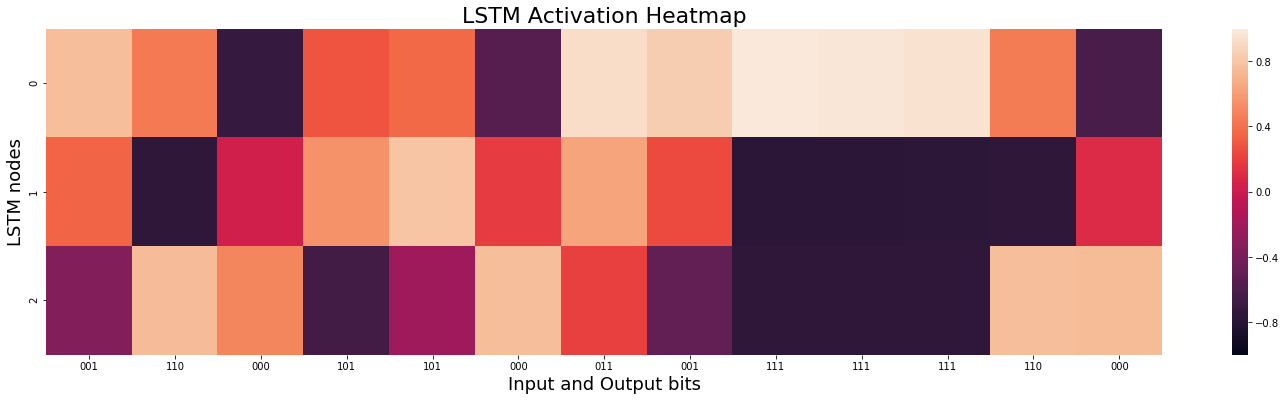

In [19]:
plot_heatmap_nodes(x_test, binary_length_test, prediction_model)

### General Visualization:

To analyse the LSTM states, we are taking some randomly generated binary input strings of maximum length 16. We are predicting the output for each input pair and storing the LSTM state values. The visual analysis is done using heatmap. 

In [20]:
# Generates random binary list of n length 

def randBinList(n, max_length):
    a = [rn.randint(0,1) for b in range(n)]
    return np.flipud(np.pad(a, (max_length-n,0), 'constant', constant_values=(0,0)))

randBinList(6,16)

array([1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [21]:
def binary_add(x1_test, x2_test):
    # Storing the actual values of sum and carry for each example 
    cin = 0
    carry_temp = []
    sum_bit_temp = []
    
    for j in range(max_length):
        a = x1_test[j]
        b = x2_test[j]
    
        carry_out = (a & b) | (cin&(a^b)) # Carry using logic gates
        carry_temp.append(carry_out)
        cin = carry_out
        
        sum_bit_out = (a^b^cin) # sum using logic gates
        sum_bit_temp.append(sum_bit_out)
        

    return (sum_bit_temp, carry_temp)

In [22]:
num_examples = 10
max_length = 16 

In [23]:
x_test = []
predicted_output = []
lstm_activation = []
carry = []
sum_bit = []

for i in range(num_examples):
    
    # Generating random input strings of random length (Max-16)
    bitstream_length = rn.randint(1,max_length)
    x1_test = randBinList(bitstream_length, max_length)
    x2_test = randBinList(bitstream_length, max_length)
    
    x_test_temp = np.expand_dims(np.array([x1_test,x2_test]).T, axis=0)
    
    # computing ground truth values for sum and carry
    (sum_bitstream, carry_bitstream) = binary_add(x1_test, x2_test)
    carry.append(carry_bitstream)
    sum_bit.append(sum_bitstream)
    
    # Predicting the addition output
    predicted_digit, lstm_1_o = predict(x_test_temp, max_length, prediction_model)
    lstm_activation.append(np.array(lstm_1_o))
    
#     #Just in case
#     x_test.append(x_test_temp)
#     predicted_output.append(np.uint8(np.array(predicted_digit) > 0.5).T[0])
#x_test = np.squeeze(np.array(x_test), axis=1)


In [24]:
carry = np.array(carry)
sum_bit = np.array(sum_bit)
lstm_activation = np.array(lstm_activation)

In [25]:
def plot_general_heatmap(lstm_node, sum_bit, carry):
    
    plt.figure(figsize=[8,6])
    plt.imshow(np.fliplr(lstm_node), cmap='magma', vmin=-1, vmax=1, aspect='auto')
    plt.colorbar()
    plt.xticks(np.arange(max_length))
    plt.yticks(np.arange(num_examples))
    plt.xlabel("String Length", fontsize=14)
    plt.ylabel("Number of examples", fontsize=14)

    for i in range(num_examples):
        for j in range(max_length):
            str_text = str(sum_bit[i, j]) + str(carry[i, j])
            text = plt.text(max_length-1-j, i, str_text,
                       ha="center", va="center", color="w")

    plt.title("Heatmap of LSTM node activation", fontsize=16)
    plt.tight_layout()
#     plt.show()

<b> Note: </b> 
1. Here, we have flipped the node value array. Thus, the right most bit is the least significant value like the normal convention. Binary addition can be viewed from right to left.
2. The values inside the heatmap represent the ground truth values of sum and carry at each bit addition time-step for all the examples. The left bit is the sum and the right bit represents the carry.

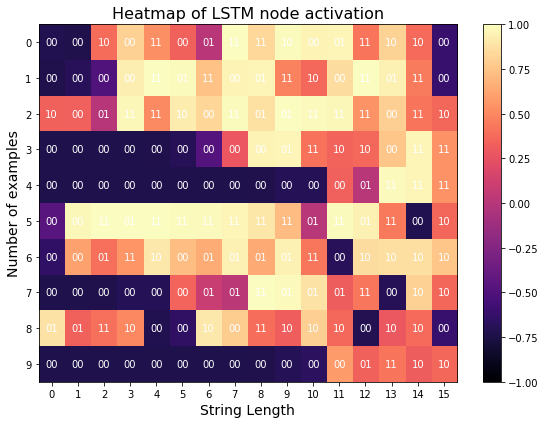

In [26]:
# LSTM Node 1
plot_general_heatmap(lstm_activation[:,:,0], sum_bit, carry)

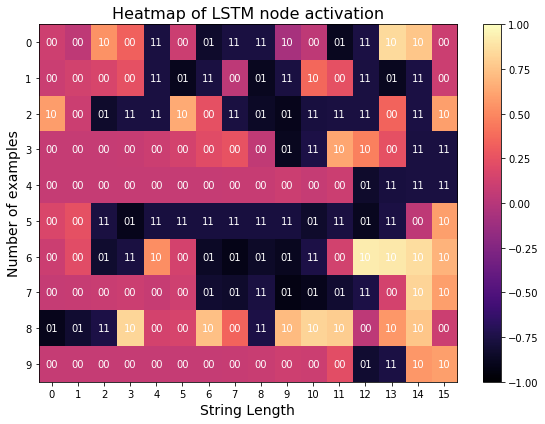

In [27]:
# LSTM Node 2
plot_general_heatmap(lstm_activation[:,:,1], sum_bit, carry)

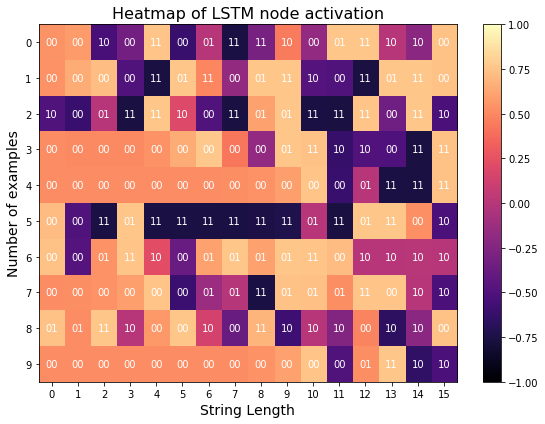

In [28]:
# LSTM Node 3
plot_general_heatmap(lstm_activation[:,:,2], sum_bit, carry)